Effective Use of Word Order for Text Categorization with Convolutional Neural Networks
 
https://arxiv.org/abs/1412.1058



In [1]:
import tarfile,os,sys, re
is_eager_exec_init=False
import psutil

In [2]:
import numpy as np
import tensorflow as tf


import pickle
import sklearn

# Use spacy to remove stop words first
import spacy
nlp = spacy.load('en')

In [3]:
%load_ext memory_profiler
%memit

peak memory: 396.40 MiB, increment: 0.10 MiB


Setup different variables in order to be able to reuse 
- data loading
- data preparation steps later on when setting up the model. (defined later on) 

In [4]:
is_data_already_loaded = False


imdb dataset should be stored in /datasets dir.

In [5]:
if not is_data_already_loaded:
    test_neg_files = []
    test_pos_files = []
    train_neg_files = []
    train_pos_files = []

    with tarfile.open('/datasets/aclImdb_v1.tar.gz') as tar:
        for mbr in tar.getmembers():
            matches = re.findall('/test/neg/.*\.txt',mbr.name)
            if len(matches)==1:
                f=tar.extractfile(mbr)
                content=f.read()        
                test_neg_files.append((mbr,content))
            matches = re.findall('/test/pos/.*\.txt',mbr.name)
            if len(matches)==1:
                f=tar.extractfile(mbr)
                content=f.read()  
                test_pos_files.append((mbr, content))
            matches = re.findall('/train/neg/.*\.txt',mbr.name)
            if len(matches)==1:
                f=tar.extractfile(mbr)
                content=f.read()        
                train_neg_files.append((mbr,content))
            matches = re.findall('/train/pos/.*\.txt',mbr.name)
            if len(matches)==1:
                f=tar.extractfile(mbr)
                content=f.read()  
                train_pos_files.append((mbr, content))


In [6]:
if not is_data_already_loaded:
    train_neg = [txt.decode("utf-8")  for file,txt in train_neg_files]
    train_pos = [txt.decode("utf-8")  for file,txt in train_pos_files]

    test_neg = [txt.decode("utf-8")  for file,txt in test_neg_files]
    test_pos = [txt.decode("utf-8")  for file,txt in test_pos_files]

In [7]:
vocab_nb = 20000

def clean_docs(docs):
    # clean docs by:
    # - removing stop words
    docs_wtho_stop = []
    for raw_doc in docs:
        doc = nlp(raw_doc)
        doc_wtho_stop = ""
        for tok in doc:
            if not tok.is_stop:
                doc_wtho_stop = doc_wtho_stop +tok.text+ " "
        docs_wtho_stop.append(doc_wtho_stop)
    return docs_wtho_stop

In [25]:
from tensorflow.keras.preprocessing.text import Tokenizer, one_hot
from tensorflow.keras.backend import one_hot, get_session, set_session
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D,MaxPool1D, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop, SGD

config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
                                    # (nothing gets printed in Jupyter, only if you run it standalone)
sess = tf.Session(config=config)
set_session(sess)


In [9]:
def docs_to_sequences(docs, vocab_nb=20000, max_length=None):
    # create the tokenizer
    t = Tokenizer(num_words=vocab_nb)
    # fit the tokenizer on the documents
    t.fit_on_texts(docs)
    # create each doc as a list of integer indices
    docs_seq_int = t.texts_to_sequences(docs)
    #print(docs_seq_int)
    
    
    doc_nb = len(docs_seq_int)
    if max_length==None:
        max_length = len(sorted(docs_seq_int,key=len, reverse=True)[0])
        print("max_lenght computed:",max_length)
    #print("max_length:",max_length)
    
    # Create a dense array of shape (doc_nb,max_length). 
    # Each cell contains a int (the indice of word)
    
    docs_seq_dense = []
    docs_seq_array = np.zeros((doc_nb,max_length),dtype=np.int16)
    #print(docs_seq_array)
    for idx, seq_int in enumerate(docs_seq_int):
        padded_seq_int = seq_int+[0]*(max_length-len(seq_int))
        doc_array = np.array(padded_seq_int, dtype=np.int16)
        docs_seq_array[idx]=doc_array[:max_length]

    return docs_seq_array
    

In [10]:
def categorical_generator(X, y, batch_size=64,vocab_nb=20000):
    # Must be able to iterate many times on the same X/y , for instance while training with many epochs.
    i=0
    while True:
        #print(i)
        #print(i)
        if i >= len(X):
            i=0
        tmp_X = X[i:batch_size+i]
        #print(tmp_X)
        batch_X= to_categorical(tmp_X,num_classes=vocab_nb)
        batch_y = y[i:batch_size+i]
        #print("cat gen: ", len(batch_X), len(batch_y))
        yield batch_X, batch_y
        i+=batch_size
    
        

## Toy Test data preparation

Data preparation logic is tested on a very small toy data set.


In [11]:
do_toy_test=True

if do_toy_test:
    toy_vocab_nb = 15
    toy_max_sent_len = 8
    docs = ['Well done!',
            'Good work, good effort',
            'Great effort guys',
            'nice work my friend',
            'Excellent job my friend!',
            'What a poor job !! ',
            'This is a shame',
            'You are a poor guy',
            'Fantastic effort my friend and brother, hell of a great job for ever I like it',
            'I like you so much my friend',
            'You worked so bad poor guy']
    cleaned_docs = clean_docs(docs)
    print(cleaned_docs)
    
    doc_sequences = docs_to_sequences(cleaned_docs, max_length=toy_max_sent_len, vocab_nb=toy_vocab_nb)
    print(doc_sequences)
    print(type(doc_sequences))
    np.save("./tst",doc_sequences)
    tmp_array = np.load("./tst.npy")
    print(tmp_array)
    
    labels=[1,1,0,1,1,0,0,0,1,0,1]
#%memit

['Well ! ', 'Good work , good effort ', 'Great effort guys ', 'nice work friend ', 'Excellent job friend ! ', 'What poor job ! ! ', 'This shame ', 'You poor guy ', 'Fantastic effort friend brother , hell great job I like ', 'I like friend ', 'You worked bad poor guy ']
[[12  0  0  0  0  0  0  0]
 [ 5  6  5  2  0  0  0  0]
 [ 7  2 13  0  0  0  0  0]
 [14  6  1  0  0  0  0  0]
 [ 3  1  0  0  0  0  0  0]
 [ 4  3  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 8  4  9  0  0  0  0  0]
 [ 2  1  7  3 10 11  0  0]
 [10 11  1  0  0  0  0  0]
 [ 8  4  9  0  0  0  0  0]]
<class 'numpy.ndarray'>
[[12  0  0  0  0  0  0  0]
 [ 5  6  5  2  0  0  0  0]
 [ 7  2 13  0  0  0  0  0]
 [14  6  1  0  0  0  0  0]
 [ 3  1  0  0  0  0  0  0]
 [ 4  3  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 8  4  9  0  0  0  0  0]
 [ 2  1  7  3 10 11  0  0]
 [10 11  1  0  0  0  0  0]
 [ 8  4  9  0  0  0  0  0]]


In [12]:
if do_toy_test:
    #print(doc_sequences,labels)
    toy_batch_size=2
    nb_iter=doc_sequences.shape[0] // toy_batch_size
    j=0
    nb_epoch=0
    for batch_x, batch_y in categorical_generator(doc_sequences,labels,batch_size=toy_batch_size,vocab_nb=toy_vocab_nb):
        #print(type(batch_x),batch_x.shape)
        #print(batch_y)
        assert (len(batch_x)<=toy_batch_size) & (len(batch_y) <=toy_batch_size)
        #print(nb_epoch,j,nb_iter)
        if j > nb_iter:
            j=0
            nb_epoch+=1
 #       if batch_x.shape[0]<test_batch_size:
 #           nb_epoch+=1
        if nb_epoch ==3:
            break
        
        j+=1



In [13]:
if do_toy_test:
    toy_batch_size=3
    toy_model = Sequential([
        Conv1D(1, 2, strides=1, activation='relu', kernel_initializer='he_normal', bias_initializer='zeros',input_shape=(toy_max_sent_len,toy_vocab_nb), kernel_regularizer=l2(0.01)),
        MaxPool1D(pool_size=2),
        Flatten(),
        Dense(1, kernel_initializer='he_normal', bias_initializer='zeros', activation='sigmoid')
    ])
    toy_model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
    tb_cb = TensorBoard(log_dir='./logs-test', histogram_freq=0, batch_size=4, 
                write_graph=True, write_grads=True, )
    
    test_steps_per_epoch=len(doc_sequences)/toy_batch_size
    print("nb steps per epoch", test_steps_per_epoch)
    train_cat_gen = categorical_generator(doc_sequences[:-2],labels[:-2],batch_size=toy_batch_size,vocab_nb=toy_vocab_nb)
    xval_cat_gen = categorical_generator(doc_sequences[-2:],labels[-2:],batch_size=toy_batch_size,vocab_nb=toy_vocab_nb)
    toy_history = toy_model.fit_generator(train_cat_gen, steps_per_epoch=test_steps_per_epoch,epochs=10, validation_data=xval_cat_gen,validation_steps=1 ,verbose=2, callbacks=[tb_cb])
    
    toy_model.summary()
    toy_model.save('./toy_model_v1')
    

Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
nb steps per epoch 3.6666666666666665
Epoch 1/10
 - 2s - loss: 0.7236 - acc: 0.5833 - val_loss: 0.6945 - val_acc: 0.5000
Epoch 2/10
 - 0s - loss: 0.7261 - acc: 0.5833 - val_loss: 0.6945 - val_acc: 0.5000
Epoch 3/10
 - 0s - loss: 0.7636 - acc: 0.5000 - val_loss: 0.6933 - val_acc: 0.5000
Epoch 4/10
 - 0s - loss: 0.7176 - acc: 0.5833 - val_loss: 0.6927 - val_acc: 0.5000
Epoch 5/10
 - 0s - loss: 0.7206 - acc: 0.5833 - val_loss: 0.6922 - val_acc: 0.5000
Epoch 6/10
 - 0s - loss: 0.7570 - acc: 0.5000 - val_loss: 0.6909 - val_acc: 0.5000
Epoch 7/10
 - 0s - loss: 0.7149 - acc: 0.5833 - val_loss: 0.6903 - val_acc: 0.5000
Epoch 8/10
 - 0s - loss: 0.7181 - acc: 0.5833 - val_loss: 0.6895 - val_acc: 0.5000
Epoch 9/10
 - 0s - loss: 0.7529 - acc: 0.5000 - val_loss: 0.6885 - val_acc: 0.5000
Epoch 10/10
 - 0s - loss: 0.7131 - acc: 0.5833 - val_loss: 0.6880 - val_acc: 0.5000
__________________________________________________

## Prepare real data

As this process is time consuming, prepared data are stored as numpy arrays. 
Var is_data_already_prepared is used to control if we need to prepare the data again. 

In [14]:

# As data as already been prepared, i will be omitted
is_data_already_prepared=True
max_sent_len = 1000
if not is_data_already_prepared:
    
    cleaned_train_neg = clean_docs(train_neg)
    seq_train_neg = docs_to_sequences(cleaned_train_neg, max_length=max_sent_len)    
    cleaned_train_pos = clean_docs(train_pos)
    seq_train_pos = docs_to_sequences(cleaned_train_pos, max_length=max_sent_len)
    np.save('./seq_train_neg',seq_train_neg)
    np.save('./seq_train_pos',seq_train_pos)
    
    cleaned_test_neg = clean_docs(test_neg)
    seq_test_neg = docs_to_sequences(cleaned_test_neg,max_length=max_sent_len)
    cleaned_test_pos = clean_docs(test_pos)
    seq_test_pos = docs_to_sequences(cleaned_test_pos, max_length=max_sent_len)
    np.save('./seq_test_neg',seq_test_neg)
    np.save('./seq_test_pos',seq_test_pos)


In [15]:
if is_data_already_prepared:
    seq_test_neg = np.load('./seq_test_neg.npy')
    seq_test_pos = np.load('./seq_test_pos.npy')
    seq_train_neg = np.load('./seq_train_neg.npy')
    seq_train_pos = np.load('./seq_train_pos.npy')
    print("prepared data loaded")

prepared data loaded


In [16]:
# Print shapes of different prepared datasets
seq_train_neg[:].shape, seq_train_pos[:].shape,seq_test_neg.shape, seq_test_pos.shape

((12500, 1000), (12500, 1000), (12500, 1000), (12500, 1000))

In [17]:
seq_train_neg.shape, type(seq_test_neg)
train_pos = np.ones((seq_train_neg.shape[0]))
train_neg = np.zeros((seq_train_neg.shape[0]))

test_pos = np.ones((seq_test_neg.shape[0]))
test_neg = np.zeros((seq_test_neg.shape[0]))

In [18]:
#seq_train = seq_train_neg + seq_train_pos
seq_train = np.append(seq_train_neg,seq_train_pos,axis=0)
seq_test = np.append(seq_test_neg,seq_test_pos,axis=0)
train_label = np.append(train_neg,train_pos,axis=0)
test_label = np.append(test_neg,test_pos,axis=0)
assert np.any(train_label[:12500]==0)
assert np.any(train_label[12500:]==1.)
assert np.any(test_label[:12500]==0)
assert np.any(test_label[12500:]==1.)
seq_train_neg.shape, seq_train.shape,seq_test.shape,train_label.shape, test_label.shape

((12500, 1000), (25000, 1000), (25000, 1000), (25000,), (25000,))

### Prepare validation data set

In [19]:
import sklearn.model_selection

In [20]:
xval_rate=0.2
X_train, X_xval, y_train, y_xval = sklearn.model_selection.train_test_split(seq_train,train_label, test_size=0.2)
assert X_train.shape==(seq_train.shape[0] * (1-xval_rate),seq_train.shape[1])
print("train & xval shapes:", X_train.shape,X_xval.shape, y_train.shape, y_xval.shape)


train & xval shapes: (20000, 1000) (5000, 1000) (20000,) (5000,)


## Create model and train it

### shallow CNN model

in order to setup the model with agility, train_nb and xval_nb can be specified with small numbers

In [ ]:
do_train=True
if do_train:

    batch_size=32
    epochs_nb = 20 
    model = Sequential([
        Conv1D(1, 2, strides=1, activation='relu', kernel_initializer='he_normal', 
               bias_initializer='zeros',input_shape=(max_sent_len,vocab_nb),
                kernel_regularizer=l2(0.01)),
        MaxPool1D(pool_size=2),
        Flatten(),
        Dense(1, kernel_initializer='he_normal', bias_initializer='zeros',activation='sigmoid')
    ])
    rmsprop = RMSprop(lr=1e-3)
    # results on sgd are by far worst than rmsprop
    sgd = SGD(lr=1e-3, momentum=0.9)
    
    model.compile(optimizer=rmsprop,
              loss='binary_crossentropy',
              metrics=['accuracy'])
    model.summary()
    
    cb_list = [
        ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=10),
        TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=32, 
                write_graph=True, write_grads=True, )
    ]
    
    # used to train only on a subset while configuring the network architecture
    train_nb = 128
    # comment next line if you want to work on a smaller dataset
    train_nb = None
    if not train_nb:
        train_nb = len(X_train)
    xval_nb = 20
    # comment next line if you want to work on a smaller dataset
    xval_nb = None
    if not xval_nb:
        xval_nb = len(X_xval)

    steps_per_epoch=train_nb// batch_size
    print("nb steps per epoch", steps_per_epoch)
    train_cat_gen = categorical_generator(X_train[:train_nb],y_train[:train_nb],batch_size=batch_size,vocab_nb=vocab_nb)
    xval_cat_gen = categorical_generator(X_xval[:xval_nb],y_xval[:xval_nb],batch_size=batch_size,vocab_nb=vocab_nb)
    history = model.fit_generator(train_cat_gen, steps_per_epoch=steps_per_epoch,epochs=epochs_nb, 
                                  validation_data=xval_cat_gen,
                                  validation_steps=1 ,verbose=1, callbacks=cb_list)
    
    
    model.save('./model_v1')
    model.save_weights('./model_w_v1')




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 999, 1)            40001     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 499, 1)            0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 499)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 500       
Total params: 40,501
Trainable params: 40,501
Non-trainable params: 0
_________________________________________________________________
nb steps per epoch 625
Epoch 1/20
625/625 [==============================] - 1270s 2s/step - loss: 0.6879 - acc: 0.5689 - val_loss: 0.6859 - val_acc: 0.5312
Epoch 2/20
625/625 [==============================] - 1276s 2s/step - loss: 0.6649 - acc: 0.6531 - val_loss: 0.65

### Plot results

In [44]:
%matplotlib inline

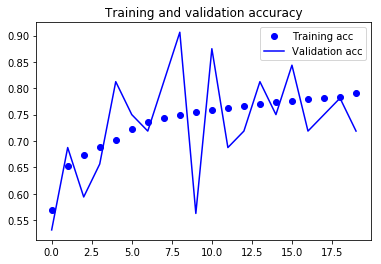

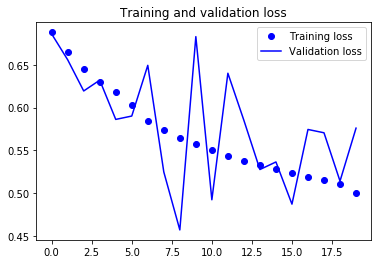

In [45]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Evaluate on test data

In [46]:
from tensorflow.keras.models import load_model

In [47]:
loaded_model = load_model('./model_v1')

In [48]:
max_test_nb = seq_test.shape[0]
step = 2000
for i in range(0,max_test_nb,step):
    
    test_from = i
    test_size=20
    test_to = test_from + test_size+1
    test_X= to_categorical(seq_test[test_from:test_to],num_classes=vocab_nb)
    test_y = test_label[test_from:test_to]
    
    test_loss, test_acc = loaded_model.evaluate(test_X, test_y)
    print('test_loss:', test_loss, ' test accuracy:', test_acc)

21/21 [==============================] - 2s 90ms/step
test_loss: 0.6589608788490295  test accuracy: 0.6666666865348816
21/21 [==============================] - 2s 84ms/step
test_loss: 0.5937330722808838  test accuracy: 0.6666666865348816
21/21 [==============================] - 2s 84ms/step
test_loss: 0.42392659187316895  test accuracy: 0.761904776096344
21/21 [==============================] - 2s 84ms/step
test_loss: 0.542691171169281  test accuracy: 0.8095238208770752
21/21 [==============================] - 2s 84ms/step
test_loss: 0.6899265050888062  test accuracy: 0.5714285969734192
21/21 [==============================] - 2s 84ms/step
test_loss: 0.5758256912231445  test accuracy: 0.5714285969734192
21/21 [==============================] - 2s 84ms/step
test_loss: 0.6991913318634033  test accuracy: 0.4761904776096344
21/21 [==============================] - 2s 84ms/step
test_loss: 0.5586634874343872  test accuracy: 0.8095238208770752
21/21 [==============================] - 2s 83ms/